# IMPORTS

In [1]:
import re
import os
import math
import time
import torch
import warnings
import numpy as np
import pandas as pd
from collections import defaultdict
from scipy.stats import beta
from scipy.special import betaln
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_fscore_support, classification_report
from accelerate import Accelerator, notebook_launcher
from torch.multiprocessing import Manager
from torch.utils.data import DataLoader, Dataset
from transformers import BertTokenizer, BertForSequenceClassification

# SETUP

In [2]:
from transformers import logging
logging.set_verbosity_error()
warnings.filterwarnings('ignore')

In [3]:
if os.path.exists('/kaggle/working/results') == False:
    os.mkdir('/kaggle/working/results')

if os.path.exists('/kaggle/working/acquired_data') == False:
    os.mkdir('/kaggle/working/acquired_data')

In [4]:
def set_seed(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic=True
    torch.backends.cudnn.benchmark=False

set_seed(42)

# GLOBAL VARIABLES

In [5]:
manager = Manager()

# Shared resources
accuracies = manager.list()
f1_micros = manager.list()
f1_macros = manager.list()
data_used = manager.list()
sampling_dur = manager.list()
new_samples = manager.list()

# Non shared resources
filename = 'hsd-besra-kfold'
epochs = 10
batch_size = 64
sequence_length = 80
min_increment = 200

# LOAD AND PREPROCESS DATA

In [6]:
data = pd.read_csv('/kaggle/input/multi-label-hate-speech-2/re_dataset.csv', encoding='latin-1')
alay_dict = pd.read_csv('/kaggle/input/multi-label-hate-speech-2/new_kamusalay.csv', encoding='latin-1', header=None)
alay_dict = alay_dict.rename(columns={0: 'original', 
                                      1: 'replacement'})

print("Shape: ", data.shape)
data.head()

Shape:  (13169, 13)


,Tweet,HS,Abusive,HS_Individual,HS_Group,HS_Religion,HS_Race,HS_Physical,HS_Gender,HS_Other,HS_Weak,HS_Moderate,HS_Strong
0,- disaat semua cowok berusaha melacak perhatia...,1,1,1,0,0,0,0,0,1,1,0,0
1,RT USER: USER siapa yang telat ngasih tau elu?...,0,1,0,0,0,0,0,0,0,0,0,0
2,"41. Kadang aku berfikir, kenapa aku tetap perc...",0,0,0,0,0,0,0,0,0,0,0,0
3,USER USER AKU ITU AKU\n\nKU TAU MATAMU SIPIT T...,0,0,0,0,0,0,0,0,0,0,0,0
4,USER USER Kaum cebong kapir udah keliatan dong...,1,1,0,1,1,0,0,0,0,0,1,0


In [7]:
def lowercase(text):
    return text.lower()

def remove_unnecessary_char(text):
    text = re.sub('\n',' ',text) # Remove every '\n'
    text = re.sub('rt',' ',text) # Remove every retweet symbol
    text = re.sub('user',' ',text) # Remove every username
    text = re.sub('url', ' ', text) # Remove every URL
    text = re.sub('((www\.[^\s]+)|(https?://[^\s]+)|(http?://[^\s]+))',' ',text) # Remove every URL
    text = re.sub(r'\b(?:x[a-fA-F0-9]{2}\s*)+\b', '', text) # Remove emoji bytecode
    text = re.sub('  +', ' ', text) # Remove extra spaces
    return text
    
def remove_nonaplhanumeric(text):
    text = re.sub('[^0-9a-zA-Z]+', ' ', text) 
    return text

alay_dict_map = dict(zip(alay_dict['original'], alay_dict['replacement']))
def normalize_alay(text):
    return ' '.join([alay_dict_map[word] if word in alay_dict_map else word for word in text.split(' ')])

print("remove_nonaplhanumeric: ", remove_nonaplhanumeric("Halooo,,,,, duniaa \x8f \xd2\1 !!"))
print("lowercase: ", lowercase("Halooo, duniaa!"))
print("remove_unnecessary_char: ", remove_unnecessary_char("Hehe\n\n RT USER USER apa kabs www.google.com\n  hehe URL xf8 x2a x89"))
print("normalize_alay: ", normalize_alay("aamiin adek abis"))

remove_nonaplhanumeric:  Halooo duniaa 
lowercase:  halooo, duniaa!
remove_unnecessary_char:  Hehe RT USER USER apa kabs hehe URL 
normalize_alay:  amin adik habis


In [8]:
def preprocess(text):
    text = lowercase(text)
    text = remove_nonaplhanumeric(text)
    text = remove_unnecessary_char(text)
    text = normalize_alay(text) 

    return text

In [9]:
data['Tweet'] = data['Tweet'].apply(preprocess)
label_columns = data.columns[1:]

# BUILD DATASET & DATALOADERS

In [10]:
class HateSpeechDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=64, use_float=True):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.use_float = use_float

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        labels = self.labels[idx]
        encoding = self.tokenizer(text, truncation=True, padding='max_length', max_length=self.max_length, return_tensors='pt')
        item = {key: val.squeeze() for key, val in encoding.items()}
        item['labels'] = torch.tensor(labels, dtype=torch.float if self.use_float else torch.long)
        return item

    def get_per_class_probs(self):
        """
        Calculate the spread of labels (0 and 1) for each class in the dataset.
        Returns:
            dict: A dictionary where keys are class indices and values are [count_0, count_1].
        """

        # Initialize a dictionary to store counts for each class
        label_counts = defaultdict(lambda: [0, 0])  # [count_0, count_1] for each class

        for i in range(len(self)):
            # Get the labels for the i-th sample
            labels = self[i]['labels']

            # Update counts for each class
            for class_idx, label in enumerate(labels):
                label_counts[class_idx][int(label)] += 1

        for key in label_counts.keys():
            total = sum(label_counts[key])
            label_counts[key] = [x / total for x in label_counts[key]]

        return label_counts

    def get_global_probs(self):
        """
        Calculate the global count of 0s and 1s across all classes in the dataset.
        Returns:
            dict: A dictionary with keys '0' and '1' representing their global counts.
        """
        global_counts = {'0': 0, '1': 0}

        for i in range(len(self)):
            # Get the labels for the i-th sample
            labels = self[i]['labels']

            # Update global counts
            for label in labels:
                global_counts[str(int(label))] += 1

        total = global_counts['0'] + global_counts['1']
        for key in global_counts.keys():
            global_counts[key] /= total

        return global_counts


# Initialize BERT tokenizer and model
tokenizer = BertTokenizer.from_pretrained('indobenchmark/indobert-base-p1')

tokenizer_config.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

In [11]:
def get_dataloaders(X_train, y_train, X_val, y_val, sequence_length=96, num_workers=4):
    train_dataset = HateSpeechDataset(X_train, y_train, tokenizer, max_length=sequence_length)
    val_dataset = HateSpeechDataset(X_val, y_val, tokenizer, max_length=sequence_length)
    train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True, num_workers=num_workers
    )
    val_loader = torch.utils.data.DataLoader(
        val_dataset, batch_size=batch_size, shuffle=False, pin_memory=True, num_workers=num_workers
    )

    return train_loader, val_loader

# TRAIN THE MODEL

In [12]:
def compute_metrics(p):
    preds = torch.tensor(p.predictions) # Sigmoid and threshold for multi-label
    labels = torch.tensor(p.label_ids)

    # Hamming accuracy: proportion of correctly predicted labels over total labels
    accuracy = (preds == labels).float().mean().item()

    # Standard multi-label precision, recall, and F1 metrics
    precision, recall, f1_micro, _ = precision_recall_fscore_support(labels, preds, average='micro', zero_division=0)
    _, _, f1_macro, _ = precision_recall_fscore_support(labels, preds, average='macro', zero_division=0)

    report = classification_report(
        labels, 
        preds, 
        target_names=['HS', 'Abusive', 'HS_Individual', 'HS_Group', 'HS_Religion', 'HS_Race', 'HS_Physical', 'HS_Gender', 'HS_Other', 'HS_Weak', 'HS_Moderate', 'HS_Strong'],
        zero_division=0
    )   
    
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_micro': f1_micro,
        'f1_macro': f1_macro,
        'report': report
    }

In [13]:
def train_model(current_train_size, train_indices, metrics, trials, i, X_train_fold, y_train_fold, X_val_fold, y_val_fold, train_labels):
    accelerator = Accelerator(mixed_precision='fp16')
    device = accelerator.device

    # Define DataLoaders using the fold's data
    current_X_train = [X_train_fold[idx] for idx in train_indices]
    current_y_train = [y_train_fold[idx] for idx in train_indices]
    train_loader, val_loader = get_dataloaders(current_X_train, current_y_train, X_val_fold, y_val_fold)

    with accelerator.main_process_first():
        model = BertForSequenceClassification.from_pretrained(
            'indobenchmark/indobert-base-p1',
            num_labels=len(train_labels),
            problem_type="multi_label_classification"
        )
        
    optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5, weight_decay=0.01)
    loss_fn = torch.nn.BCEWithLogitsLoss()

    # Freeze layers
    for name, param in model.named_parameters():
        if "encoder.layer" in name:
            try:
                if int(name.split(".")[3]) < 6:
                    param.requires_grad = False
            except ValueError:
                continue

    model, optimizer, train_loader, val_loader = accelerator.prepare(model, optimizer, train_loader, val_loader)

    best_result = None
    for epoch in range(epochs):
        model.train()
        epoch_loss = 0
        
        for batch in train_loader:
            inputs = {key: val for key, val in batch.items() if key != 'labels'}
            labels = batch['labels']
            optimizer.zero_grad()
            outputs = model(**inputs)
            loss = loss_fn(outputs.logits, labels)
            accelerator.backward(loss)
            optimizer.step()
            epoch_loss += loss.item()

        # Evaluation
        model.eval()
        all_preds, all_labels = [], []
        with torch.no_grad():
            for batch in val_loader:
                inputs = {key: val for key, val in batch.items() if key != 'labels'}
                labels = batch['labels']
                outputs = model(**inputs)
                preds = torch.sigmoid(outputs.logits).round()
                all_preds.append(accelerator.gather(preds))
                all_labels.append(accelerator.gather(labels))
        
        all_preds = torch.cat(all_preds).cpu().numpy()
        all_labels = torch.cat(all_labels).cpu().numpy()
        result = compute_metrics(type('EvalOutput', (object,), {'predictions': all_preds, 'label_ids': all_labels}))

        if best_result is None or result['f1_micro'] >= best_result['f1_micro']:
            accelerator.wait_for_everyone()
            unwrapped_model = accelerator.unwrap_model(model)
            # Differentiate saved models by fold and ensemble member index 'i'
            unwrapped_model.save_pretrained(
                f'{filename}-fold-{trials+1}-model-{i+1}',
                is_main_process=accelerator.is_main_process,
                save_function=accelerator.save,
            )
            best_result = result

        accelerator.print(f"Epoch {epoch + 1}/{epochs}, Train Loss: {round(epoch_loss / len(train_loader), 4)}, Accuracy: {round(result['accuracy'], 4)}, F1 Micro: {round(result['f1_micro'], 4)}, F1 Macro: {round(result['f1_macro'], 4)}")

    # Update shared metrics lists
    if accelerator.is_local_main_process:
        metrics[0].append(best_result['accuracy'])
        metrics[1].append(best_result['f1_micro'])
        metrics[2].append(best_result['f1_macro'])

# PLOT RESULT

In [14]:
import matplotlib.pyplot as plt

def plot_result(data_used, accuracies, f1_micros, f1_macros):
    fig, axs = plt.subplots(1, 3, figsize=(21, 5))
    data_used = [round(data / total_data * 100, 1) for data in data_used]

    # Plot for Accuracy
    axs[0].plot(data_used, accuracies, label="Accuracy", color="blue")
    axs[0].set_xlabel("Percentage of data used")
    axs[0].set_title("Accuracy")
    axs[0].set_xticks(data_used)

    # Plot for F1 Micro
    axs[1].plot(data_used, f1_micros, label="F1 Micro", color="orange")
    axs[1].set_xlabel("Percentage of data used")
    axs[1].set_title("F1 Micro")
    axs[1].set_xticks(data_used)

    # Plot for F1 Macro
    axs[2].plot(data_used, f1_macros, label="F1 Macro", color="green")
    axs[2].set_xlabel("Percentage of data used")
    axs[2].set_title("F1 Macro")
    axs[2].set_xticks(data_used)

    # Adjust layout and show the plots
    plt.tight_layout()
    plt.show()

# QUERY STRATEGY

In [15]:
def beta_score(predicted_prob_one, true_outcome, alpha_param=0.1, beta_param=3.0):
    epsilon = 1e-9
    safe_prob = np.clip(predicted_prob_one, epsilon, 1.0 - epsilon)

    if true_outcome == 1:
        # Arguments for the betaln function when the true outcome is 1
        arg1 = alpha_param
        arg2 = beta_param + 1
        arg3 = alpha_param + safe_prob
        arg4 = beta_param + 1 - safe_prob
        if not (arg1 > 0 and arg2 > 0 and arg3 > 0 and arg4 > 0):
            return -1e9
        return -betaln(arg1, arg2) + betaln(arg3, arg4)
    elif true_outcome == 0:
        # Arguments for the betaln function when the true outcome is 0
        arg1 = alpha_param + 1
        arg2 = beta_param
        arg3 = alpha_param + 1 - safe_prob
        arg4 = beta_param + safe_prob
        if not (arg1 > 0 and arg2 > 0 and arg3 > 0 and arg4 > 0):
            return -1e9
        return -betaln(arg1, arg2) + betaln(arg3, arg4)
    else:
        raise ValueError("Invalid label: true_outcome must be 0 or 1.")

def calculate_expected_beta_score(predicted_prob_one, alpha_param, beta_param):
    score_if_one = beta_score(predicted_prob_one, 1, alpha_param, beta_param)
    score_if_zero = beta_score(predicted_prob_one, 0, alpha_param, beta_param)
    
    expected_score = predicted_prob_one * score_if_one + (1.0 - predicted_prob_one) * score_if_zero
    return expected_score

def get_ensemble_predictions_for_batch(ensemble_models, input_ids, attention_mask, device):
    individual_model_probs_list = []
    with torch.no_grad():
        for model_instance in ensemble_models:
            model_instance.eval()
            model_instance.to(device)
            outputs = model_instance(input_ids.to(device), attention_mask=attention_mask.to(device))
            probs = torch.sigmoid(outputs.logits)
            individual_model_probs_list.append(probs)

        if not individual_model_probs_list:
            return torch.empty(0, device=device), []

        individual_probs_tensor = torch.stack(individual_model_probs_list)
        average_probs = torch.mean(individual_probs_tensor, dim=0)

    return average_probs, individual_model_probs_list

def besra_sampling(
    ensemble_models,
    unlabeled_data,
    train_indices,
    remaining_indices,
    estimation_data,
    tokenizer,
    num_classes,
    sampling_dur,
    new_samples,
    trials,
    X_train_fold,
    y_train_fold,
    alpha_param=0.1,
    beta_param=3.0,
    n_clusters=min_increment,
):
    accelerator = Accelerator(mixed_precision="fp16")
    device = accelerator.device

    unlabeled_dataset = HateSpeechDataset(unlabeled_data,
                                        np.zeros((len(unlabeled_data), num_classes)),
                                        tokenizer,
                                        max_length=sequence_length) 
    unlabeled_dataloader = DataLoader(unlabeled_dataset, batch_size=batch_size, num_workers=4, pin_memory=True) 

    current_train_size = len(train_indices)

    estimation_dataset = HateSpeechDataset(estimation_data,
                                        np.zeros((len(estimation_data), num_classes)),
                                        tokenizer,
                                        max_length=sequence_length) # sequence_length
    estimation_dataloader = DataLoader(estimation_dataset, batch_size=len(estimation_dataset), num_workers=4, pin_memory=True)
    estimation_dataloader, unlabeled_dataloader = accelerator.prepare(estimation_dataloader, unlabeled_dataloader)

    for model in ensemble_models:
        model.to(device)
        model.eval()

    start_time = time.time()
    candidate_scores = []
    all_estimation_avg_probs = []
    all_estimation_individual_probs_by_model = []
    all_candidate_avg_probs = []
    all_candidate_individual_probs_by_model = []

    # Pre compute predictions for all estimation and candidate samples
    for est_batch in estimation_dataloader:
        est_input_ids = est_batch['input_ids']
        est_attention_mask = est_batch['attention_mask']
        est_avg_probs_batch, est_indiv_probs_batch = get_ensemble_predictions_for_batch(ensemble_models, est_input_ids, est_attention_mask, device)
        all_estimation_avg_probs.append(accelerator.gather_for_metrics(est_avg_probs_batch))

        if not all_estimation_individual_probs_by_model:
            all_estimation_individual_probs_by_model = [[] for _ in est_indiv_probs_batch]
        for model_idx, probs in enumerate(est_indiv_probs_batch):
            all_estimation_individual_probs_by_model[model_idx].append(accelerator.gather_for_metrics(probs))

    for cand_batch in unlabeled_dataloader:
        cand_input_ids = cand_batch['input_ids']
        cand_attention_mask = cand_batch['attention_mask']
        cand_avg_probs_batch, cand_indiv_probs_batch = get_ensemble_predictions_for_batch(ensemble_models, cand_input_ids, cand_attention_mask, device)
        all_candidate_avg_probs.append(accelerator.gather_for_metrics(cand_avg_probs_batch))

        if not all_candidate_individual_probs_by_model:
             all_candidate_individual_probs_by_model = [[] for _ in cand_indiv_probs_batch]
        for model_idx, probs in enumerate(cand_indiv_probs_batch):
            all_candidate_individual_probs_by_model[model_idx].append(accelerator.gather_for_metrics(probs))

    # Concatenate all batch predictions into single tensors
    all_estimation_avg_probs = torch.cat(all_estimation_avg_probs, dim=0)
    all_estimation_individual_probs = [torch.cat(model_probs, dim=0) for model_probs in all_estimation_individual_probs_by_model]
    all_candidate_avg_probs = torch.cat(all_candidate_avg_probs, dim=0)
    all_candidate_individual_probs = [torch.cat(model_probs, dim=0) for model_probs in all_candidate_individual_probs_by_model]

    accelerator.wait_for_everyone()

    # Score change calculation
    for candidate_index in range(len(all_candidate_avg_probs)):
        candidate_avg_probs_for_sample = all_candidate_avg_probs[candidate_index]
        candidate_individual_probs_for_sample = [m_probs[candidate_index] for m_probs in all_candidate_individual_probs]
        candidate_delta_q_score = 0.0

        for estimation_index in range(len(all_estimation_avg_probs)):
            estimation_avg_probs_for_sample = all_estimation_avg_probs[estimation_index]
            estimation_individual_probs_for_sample = [m_probs[estimation_index] for m_probs in all_estimation_individual_probs]

            # Calculate the initial expected score on the estimation sample before any update
            initial_expected_score_on_estimation_sample = 0.0
            for estimation_class_index in range(num_classes):
                prob_one_avg_for_est_class = estimation_avg_probs_for_sample[estimation_class_index].item()
                initial_expected_score_on_estimation_sample += calculate_expected_beta_score(prob_one_avg_for_est_class, alpha_param, beta_param)

            delta_q_for_one_estimation_sample = 0.0
            for candidate_class_index in range(num_classes):
                expected_score_after_update = 0.0
                for hypothetical_candidate_label in [0, 1]:
                    prob_one_avg_for_candidate_class = candidate_avg_probs_for_sample[candidate_class_index].item()
                    prob_of_hypothetical_label_avg = prob_one_avg_for_candidate_class if hypothetical_candidate_label == 1 else (1.0 - prob_one_avg_for_candidate_class)

                    # Bayesian Update by model reweighting
                    model_weights = []
                    for model_index in range(len(ensemble_models)):
                        prob_one_individual_for_candidate_class = candidate_individual_probs_for_sample[model_index][candidate_class_index].item()
                        prob_of_hypothetical_label_individual = prob_one_individual_for_candidate_class if hypothetical_candidate_label == 1 else (1.0 - prob_one_individual_for_candidate_class)
                        model_weights.append(prob_of_hypothetical_label_individual)

                    sum_model_weights = sum(model_weights)
                    if sum_model_weights < 1e-9:
                        normalized_model_weights = [1.0 / len(ensemble_models)] * len(ensemble_models)
                    else:
                        normalized_model_weights = [w / sum_model_weights for w in model_weights]

                    reweighted_prob_one_for_est_class = 0.0

                    # Reweight the individual model probabilities for the candidate class
                    for model_index in range(len(ensemble_models)):
                        prob_one_individual_for_est_class = estimation_individual_probs_for_sample[model_index][candidate_class_index].item()
                        reweighted_prob_one_for_est_class += normalized_model_weights[model_index] * prob_one_individual_for_est_class

                    # Calculate new scores
                    updated_expected_score_on_estimation_sample = calculate_expected_beta_score(reweighted_prob_one_for_est_class, alpha_param, beta_param)
                    expected_score_after_update += prob_of_hypothetical_label_avg * updated_expected_score_on_estimation_sample

                delta_q_for_one_estimation_sample += (expected_score_after_update - initial_expected_score_on_estimation_sample)
            candidate_delta_q_score += delta_q_for_one_estimation_sample
        candidate_scores.append(candidate_delta_q_score)

    # K-Means Clustering and Selection
    accelerator.wait_for_everyone()
    if accelerator.is_main_process:
        candidate_scores = np.array(candidate_scores)
        candidate_scores = candidate_scores.reshape(-1, 1)
    
        accelerator.print(f"BESRA Uncertainty Score Threshold {np.percentile(candidate_scores, 90)}")
    
        target_samples = math.ceil(0.1 * len(unlabeled_data)) 
        collected_indices = set()
        thresholds = []
    
        # Check nearest checkpoint
        nearest_cp = 0
        arrived_at_cp = False
        for cp in checkpoints:
            if cp > current_train_size:
                nearest_cp = cp
                break
    
        # Determine number of maximum samples to be acquired
        if target_samples <= n_clusters and n_clusters < nearest_cp - current_train_size:
            target_samples = n_clusters
        elif target_samples > n_clusters and target_samples < nearest_cp - current_train_size:
            target_samples = target_samples
        else:
            arrived_at_cp = True
            target_samples = nearest_cp - current_train_size
    
        # No clustering needed when there's little data left
        if current_train_size >= checkpoints[len(checkpoints)-1] - min_increment:
            end_time = time.time()
            duration = end_time - start_time
            
            temp = train_indices.copy()
            temp.extend(remaining_indices)
            
            # Save acquired data up to checkpoint
            acquired_data = pd.DataFrame({
                'processed_text': [X_train_fold[i] for i in temp],
                'HS': [y_train_fold[i][0] for i in temp],
                'Abusive': [y_train_fold[i][1] for i in temp],
                'HS_Individual': [y_train_fold[i][2] for i in temp],
                'HS_Group': [y_train_fold[i][3] for i in temp],
                'HS_Religion': [y_train_fold[i][4] for i in temp],
                'HS_Race': [y_train_fold[i][5] for i in temp],
                'HS_Physical': [y_train_fold[i][6] for i in temp],
                'HS_Gender': [y_train_fold[i][7] for i in temp],
                'HS_Other': [y_train_fold[i][8] for i in temp],
                'HS_Weak': [y_train_fold[i][9] for i in temp],
                'HS_Moderate': [y_train_fold[i][10] for i in temp],
                'HS_Strong': [y_train_fold[i][11] for i in temp],
            })
            acquired_data.to_csv(f'acquired_data/{filename}-{trials+1}-data-{nearest_cp}.csv', index=False)
    
            print("Nearest checkpoint:", nearest_cp)
            print("Acquired samples:", len(remaining_indices))
            print(f"Sampling duration: {duration} seconds")
            
            sampling_dur.append(duration)
            for i in remaining_indices:
                new_samples.append(i)
    
        else:
            # Cluster the data based on its embeddings
            kmeans=KMeans(n_clusters=n_clusters, n_init=1)
            kmeans.fit(candidate_scores)
            
            for cluster_id in range(n_clusters):
                # Cluster center and indices of samples in the current cluster
                cluster_center = kmeans.cluster_centers_[cluster_id]
                cluster_indices = np.where(kmeans.labels_ == cluster_id)[0]
            
                if cluster_indices.size == 0:
                    # Skip clusters with no members
                    print(f"Cluster {cluster_id} has no members, skipping.")
                    continue
            
                # Calculate distances of each point in the cluster from the cluster center
                cluster_distances = np.linalg.norm(candidate_scores[cluster_indices] - cluster_center, axis=1)
            
                # Determine the local threshold (10th percentile of closest distances to cluster center)
                local_threshold = np.percentile(cluster_distances, 90)
                thresholds.append(local_threshold)
            
                below_threshold_indices = cluster_indices[cluster_distances >= local_threshold]
                collected_indices.update(below_threshold_indices)
    
            # To handle multiple points with same distance
            if len(collected_indices) > target_samples:
                collected_indices = np.array(list(collected_indices))
                np.random.shuffle(collected_indices)
                collected_indices = collected_indices[:target_samples]
                
            end_time = time.time() 
            duration = end_time - start_time 
    
            if arrived_at_cp:
                temp = train_indices.copy()
                temp.extend(collected_indices)
                
                # Save acquired data up to checkpoint
                acquired_data = pd.DataFrame({
                    'processed_text': [X_train_fold[i] for i in temp],
                    'HS': [y_train_fold[i][0] for i in temp],
                    'Abusive': [y_train_fold[i][1] for i in temp],
                    'HS_Individual': [y_train_fold[i][2] for i in temp],
                    'HS_Group': [y_train_fold[i][3] for i in temp],
                    'HS_Religion': [y_train_fold[i][4] for i in temp],
                    'HS_Race': [y_train_fold[i][5] for i in temp],
                    'HS_Physical': [y_train_fold[i][6] for i in temp],
                    'HS_Gender': [y_train_fold[i][7] for i in temp],
                    'HS_Other': [y_train_fold[i][8] for i in temp],
                    'HS_Weak': [y_train_fold[i][9] for i in temp],
                    'HS_Moderate': [y_train_fold[i][10] for i in temp],
                    'HS_Strong': [y_train_fold[i][11] for i in temp],
                })
        
                acquired_data.to_csv(f'acquired_data/{filename}-{trials+1}-data-{nearest_cp}.csv', index=False)
            
            print("Nearest checkpoint:", nearest_cp)
            # print(f"Thresholds: {thresholds}")
            print("Acquired samples:", len(collected_indices))
            print(f"Sampling duration: {duration} seconds")
            
            sampling_dur.append(duration)
            for i in collected_indices:
                new_samples.append(remaining_indices[i])
    
            # threshold_data = pd.DataFrame({
            #     'Threshold': thresholds
            # })
            # threshold_data.to_csv(f"results/{filename}-thresholds-{trials+1}-{current_train_size}.csv", index=False)

# MAIN LOOP

In [16]:
from sklearn.model_selection import KFold

N_SPLITS = 5
RANDOM_SEED = 42

# Prepare data for K-Fold
label_columns = data.columns[1:]
X = data['Tweet'].values
y = data[label_columns].values
kf = KFold(n_splits=N_SPLITS, shuffle=True, random_state=RANDOM_SEED)

all_fold_accuracies = []
all_fold_f1_micros = []
all_fold_f1_macros = []
all_fold_data_used = []

for fold, (train_index, val_index) in enumerate(kf.split(X)):
    if fold == 2:
        print("===============================================")
        print(f"STARTING FOLD {fold + 1}/{N_SPLITS}")
        print("===============================================")
    
        X_train_fold, X_val_fold = X[train_index], X[val_index]
        y_train_fold, y_val_fold = y[train_index], y[val_index]
    
        train_fold_df = pd.DataFrame(X_train_fold, columns=['Tweet'])
        train_fold_df[label_columns] = y_train_fold
    
        val_fold_df = pd.DataFrame(X_val_fold, columns=['Tweet'])
        val_fold_df[label_columns] = y_val_fold
    
        fold_data_dir = 'kfold_splits'
        if not os.path.exists(fold_data_dir):
            os.makedirs(fold_data_dir)
    
        train_fold_df.to_csv(f'{fold_data_dir}/train_fold_{fold + 1}.csv', index=False)
        val_fold_df.to_csv(f'{fold_data_dir}/val_fold_{fold + 1}.csv', index=False)
    
        # Shared resources for this fold's processes
        accuracies = manager.list()
        f1_micros = manager.list()
        f1_macros = manager.list()
        data_used = manager.list()
        sampling_dur = manager.list()
        
        set_seed(RANDOM_SEED + fold)
        
        # Define the initial labeled pool from the current fold's training data
        total_train_fold_size = len(X_train_fold) + len(X_val_fold)
        initial_train_size = int(0.05 * total_train_fold_size)
        
        train_indices = np.random.choice(range(len(X_train_fold)), initial_train_size, replace=False).tolist()
        remaining_indices = list(set(range(len(X_train_fold))) - set(train_indices))
        current_train_size = initial_train_size
    
        checkpoints = [
            # int(0.66 * total_train_fold_size),
            int(0.5 * total_train_fold_size), 
            int(0.6 * total_train_fold_size),
            int(0.7 * total_train_fold_size),
            len(X_train_fold)
        ]
        
        fold_start_time = time.time()
        
        while current_train_size < total_train_fold_size:
            model_accuracies = manager.list()
            model_f1_micros = manager.list()
            model_f1_macros = manager.list()
    
            ensemble_seeds = [RANDOM_SEED + fold + j for j in range(3)]
            for j, seed in enumerate(ensemble_seeds):
                set_seed(seed)
                train_args = (
                    current_train_size, train_indices, (model_accuracies, model_f1_micros, model_f1_macros), 
                    fold, j, X_train_fold, y_train_fold, X_val_fold, y_val_fold, label_columns
                )
                notebook_launcher(train_model, train_args, num_processes=2)
    
            data_used.append(current_train_size)
            accuracies.append(np.mean(model_accuracies))
            f1_micros.append(np.mean(model_f1_micros))
            f1_macros.append(np.mean(model_f1_macros))
            print(f"\nFold {fold+1} - Averaged F1-Micro for {current_train_size} samples: {np.mean(model_f1_micros):.4f}\n")
            
            # Stop if we've reached the last checkpoint
            if current_train_size >= checkpoints[-1]:
                break
    
            ensemble_models = []
            for j in range(3):
                model = BertForSequenceClassification.from_pretrained(f'{filename}-fold-{fold+1}-model-{j+1}')
                ensemble_models.append(model)
    
            # Perform query strategy
            estimation_pool_indices = np.random.choice(remaining_indices, size=min(16, int(0.1 * len(remaining_indices))), replace=False).tolist()
            estimation_pool_data = [X_train_fold[i] for i in estimation_pool_indices]
            new_samples_shared = manager.list()
            
            sampling_args = (
                ensemble_models, 
                [X_train_fold[i] for i in remaining_indices], 
                train_indices, 
                remaining_indices, 
                estimation_pool_data,
                tokenizer, 
                y_train_fold.shape[1],
                sampling_dur, 
                new_samples_shared, 
                fold,
                X_train_fold,
                y_train_fold
            )
            notebook_launcher(besra_sampling, sampling_args, num_processes=2)
            
            # Update the pools
            newly_acquired_indices = list(new_samples_shared)
            train_indices.extend(newly_acquired_indices)
            remaining_indices = list(set(remaining_indices) - set(newly_acquired_indices))
        
            current_train_size = len(train_indices)
            print(f"\nFold {fold + 1} - New train size: {current_train_size}\n")
        
        fold_end_time = time.time()
        print(f"\nFOLD {fold + 1} COMPLETED in {fold_end_time - fold_start_time:.2f} seconds")
        
        # Store the results for this fold
        all_fold_data_used.append(list(data_used))
        all_fold_accuracies.append(list(accuracies))
        all_fold_f1_micros.append(list(f1_micros))
        all_fold_f1_macros.append(list(f1_macros))

STARTING FOLD 3/5
Launching training on 2 GPUs.
Epoch 1/10, Train Loss: 0.589, Accuracy: 0.8192, F1 Micro: 0.3329, F1 Macro: 0.121
Epoch 2/10, Train Loss: 0.462, Accuracy: 0.8328, F1 Micro: 0.1424, F1 Macro: 0.043
Epoch 3/10, Train Loss: 0.4096, Accuracy: 0.8379, F1 Micro: 0.1751, F1 Macro: 0.0644
Epoch 4/10, Train Loss: 0.3943, Accuracy: 0.8443, F1 Micro: 0.243, F1 Macro: 0.0848
Epoch 5/10, Train Loss: 0.3778, Accuracy: 0.8511, F1 Micro: 0.3367, F1 Macro: 0.1065
Epoch 6/10, Train Loss: 0.361, Accuracy: 0.8584, F1 Micro: 0.3902, F1 Macro: 0.1412
Epoch 7/10, Train Loss: 0.3343, Accuracy: 0.8714, F1 Micro: 0.5554, F1 Macro: 0.2443
Epoch 8/10, Train Loss: 0.3088, Accuracy: 0.8736, F1 Micro: 0.5244, F1 Macro: 0.246
Epoch 9/10, Train Loss: 0.2861, Accuracy: 0.8776, F1 Micro: 0.6054, F1 Macro: 0.2994
Epoch 10/10, Train Loss: 0.2691, Accuracy: 0.8796, F1 Micro: 0.6353, F1 Macro: 0.3468
Launching training on 2 GPUs.
Epoch 1/10, Train Loss: 0.5949, Accuracy: 0.8269, F1 Micro: 0.117, F1 Macro: 0

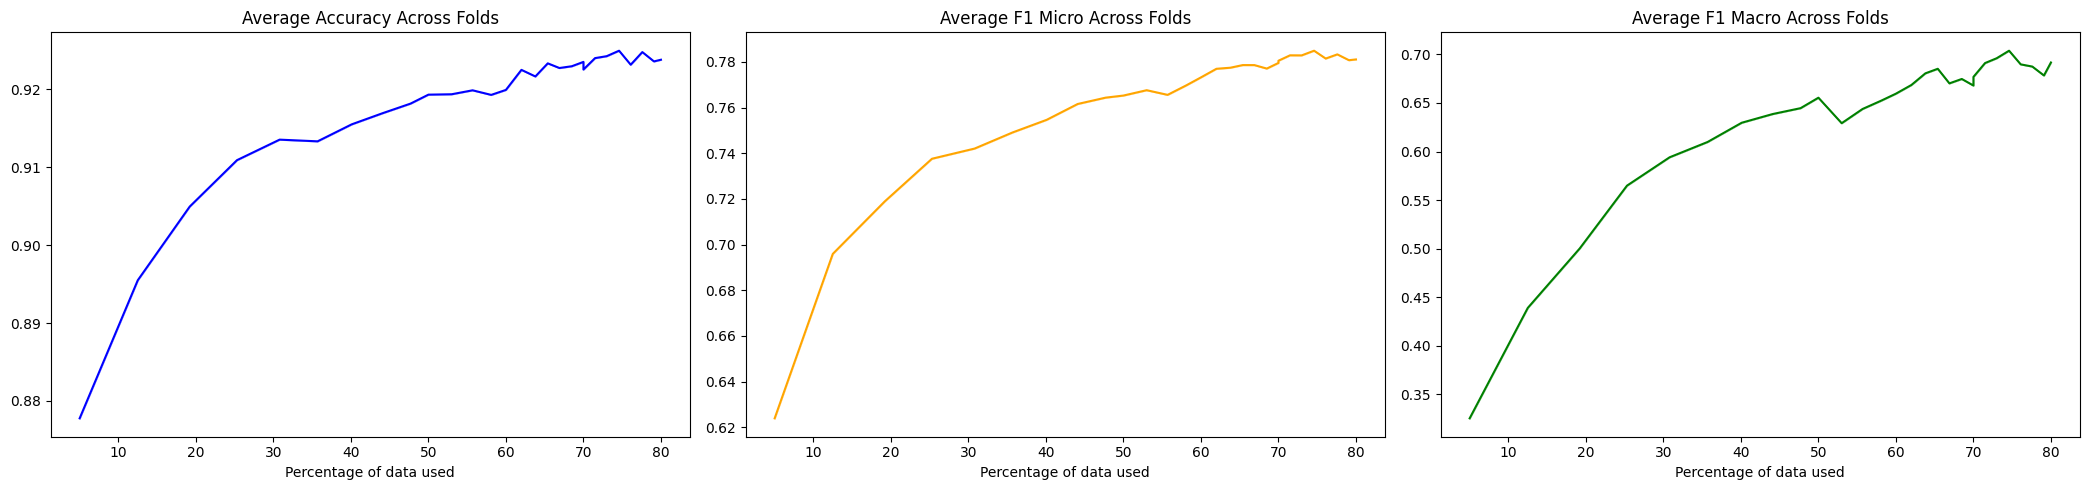

In [17]:
import matplotlib.pyplot as plt
import numpy as np

common_data_points = sorted(list(set(point for fold_points in all_fold_data_used for point in fold_points)))

# Interpolate metrics for each fold to the common data points
avg_accuracies = []
avg_f1_micros = []
avg_f1_macros = []
std_accuracies = []
std_f1_micros = []
std_f1_macros = []

for point in common_data_points:
    point_accuracies = []
    point_f1_micros = []
    point_f1_macros = []
    for i in range(1):
        sorted_indices = np.argsort(all_fold_data_used[i])
        sorted_data = np.array(all_fold_data_used[i])[sorted_indices]
        
        sorted_acc = np.array(all_fold_accuracies[i])[sorted_indices]
        sorted_f1m = np.array(all_fold_f1_micros[i])[sorted_indices]
        sorted_f1ma = np.array(all_fold_f1_macros[i])[sorted_indices]
        
        # Use interpolation to estimate the metric value at the common 'point'
        point_accuracies.append(np.interp(point, sorted_data, sorted_acc))
        point_f1_micros.append(np.interp(point, sorted_data, sorted_f1m))
        point_f1_macros.append(np.interp(point, sorted_data, sorted_f1ma))
    
    avg_accuracies.append(np.mean(point_accuracies))
    avg_f1_micros.append(np.mean(point_f1_micros))
    avg_f1_macros.append(np.mean(point_f1_macros))
    
    std_accuracies.append(np.std(point_accuracies))
    std_f1_micros.append(np.std(point_f1_micros))
    std_f1_macros.append(np.std(point_f1_macros))

# Convert to numpy arrays for easier plotting
avg_accuracies = np.array(avg_accuracies)
avg_f1_micros = np.array(avg_f1_micros)
avg_f1_macros = np.array(avg_f1_macros)
std_accuracies = np.array(std_accuracies)
std_f1_micros = np.array(std_f1_micros)
std_f1_macros = np.array(std_f1_macros)

fig, axs = plt.subplots(1, 3, figsize=(21, 5))
data_used_percent = [round(data / len(X) * 100, 1) for data in common_data_points]

# Plot for Accuracy
axs[0].plot(data_used_percent, avg_accuracies, label="Avg Accuracy", color="blue")
axs[0].fill_between(data_used_percent, avg_accuracies - std_accuracies, avg_accuracies + std_accuracies, color='blue', alpha=0.2)
axs[0].set_xlabel("Percentage of data used")
axs[0].set_title("Average Accuracy Across Folds")

# Plot for F1 Micro
axs[1].plot(data_used_percent, avg_f1_micros, label="Avg F1 Micro", color="orange")
axs[1].fill_between(data_used_percent, avg_f1_micros - std_f1_micros, avg_f1_micros + std_f1_micros, color='orange', alpha=0.2)
axs[1].set_xlabel("Percentage of data used")
axs[1].set_title("Average F1 Micro Across Folds")

# Plot for F1 Macro
axs[2].plot(data_used_percent, avg_f1_macros, label="Avg F1 Macro", color="green")
axs[2].fill_between(data_used_percent, avg_f1_macros - std_f1_macros, avg_f1_macros + std_f1_macros, color='green', alpha=0.2)
axs[2].set_xlabel("Percentage of data used")
axs[2].set_title("Average F1 Macro Across Folds")

# Adjust layout and show the plots
plt.tight_layout()
plt.show()

for i in range(1):
    result = pd.DataFrame({
        'Data Used': all_fold_data_used[i],
        'Accuracy': all_fold_accuracies[i],
        'F1 Micro': all_fold_f1_micros[i],
        'F1 Macro': all_fold_f1_macros[i],
    })

    result.to_csv(f'results/{filename}-3-results.csv', index=False)